In [125]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("/content")

# Step 1: Data acquisition

Monthly user data are collected from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.

*   The Legacy Pagecounts API (documentation, endpoint) provides access to desktop and mobile traffic data from December 2007 through July 2016.
*   The Pageviews API (documentation, endpoint) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

These data are then been stored in five JSON files:

*   pagecounts_mobile-site_200712-201607
*   pagecounts_desktop-site_200712-201607
*   pageviews_desktop_201507-202109
*   pageviews_mobile-web_201507-202109
*   pageviews_mobile-app_201507-202109


In [126]:
endpoint_legacy_mobile = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/mobile-site/monthly/2007120100/2016080100'
endpoint_legacy_desktop = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2007120100/2016080100'

endpoint_pageviews_desktop = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2021100100'
endpoint_pageviews_mobileweb = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-web/user/monthly/2015070100/2021100100'
endpoint_pageviews_mobileapp = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-app/user/monthly/2015070100/2021100100'

endpoint_all_views = [endpoint_legacy_mobile, endpoint_legacy_desktop, endpoint_pageviews_desktop, endpoint_pageviews_mobileweb, endpoint_pageviews_mobileapp]
filenames = ['pagecounts_mobile-site_200712-201607', 'pagecounts_desktop-site_200712-201607', 'pageviews_desktop_201507-202109', 'pageviews_mobile-web_201507-202109', 'pageviews_mobile-app_201507-202109']

headers = {
    'User-Agent': 'https://github.com/ningjis',
    'From': 'ningjis@uw.edu'
}

In [127]:
for i in range(len(endpoint_all_views)):
    call = requests.get(endpoint_all_views[i], headers=headers)
    response = call.json()
    f = open(filenames[i], 'w')
    f.write(json.dumps(json.loads(call.content)))
    print(filenames[i] + ' saved successfully!')
    f.close()

pagecounts_mobile-site_200712-201607 saved successfully!
pagecounts_desktop-site_200712-201607 saved successfully!
pageviews_desktop_201507-202109 saved successfully!
pageviews_mobile-web_201507-202109 saved successfully!
pageviews_mobile-app_201507-202109 saved successfully!


# Step 2: Data processing

In this step, the five JSON files from above are indexed with the combination of four-digit year (YYYY) and two-digit month (MM). Some of the columns from the raw data, such as granularity, project, and agent, are dropped during data processing.  The monthly values of mobile-app and mobile-web data collected from the Pageviews API are combined in order to create a total mobile traffic count for each month. The desktop and mobile traffic data from both APIs are then merged into a single CSV file with the following headers:


*   year
*   month
*   pagecount_all_views
*   pagecount_desktop_views
*   pagecount_mobile_views
*   pageview_all_views
*   pageview_desktop_views
*   pageview_mobile_views


In [128]:
def normalize_json(df):
    for i in range(len(df)):
        if i==0:
            df_normalized = pd.json_normalize(df['items'][0])
        else:
            df_normalized = pd.concat([df_normalized, pd.json_normalize(df['items'][i])])
    df_normalized['year'] = df_normalized['timestamp'].apply(lambda x: x[:4])
    df_normalized['month'] = df_normalized['timestamp'].apply(lambda x: x[4:6])
    df_normalized = df_normalized.drop(['timestamp', 'granularity', 'project'], axis=1)
    df_normalized = df_normalized.set_index(['year', 'month'])
    return df_normalized

def normalize_pagecounts(df):
    df_normalized = normalize_json(df)
    ##df_normalized['count'].apply(lambda x: int(x))
    return df_normalized

def normalize_pageviews(df):
    df_normalized = normalize_json(df)
    df_normalized = df_normalized.drop(['agent'], axis=1)
    ##df_normalized['views'].apply(lambda x: int(x))
    return df_normalized

In [129]:
df_cm = pd.read_json('pagecounts_mobile-site_200712-201607')
df_cd = pd.read_json('pagecounts_desktop-site_200712-201607')
df_vd = pd.read_json('pageviews_desktop_201507-202109')
df_vmw = pd.read_json('pageviews_mobile-web_201507-202109')
df_vma = pd.read_json('pageviews_mobile-app_201507-202109')

df_cm = normalize_pagecounts(df_cm)
df_cd = normalize_pagecounts(df_cd)
df_vd = normalize_pageviews(df_vd)
df_vmw = normalize_pageviews(df_vmw)
df_vma = normalize_pageviews(df_vma)

#df_vmw[df_vmw.index.duplicated()]

#For data collected from the Pageviews API
#combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
df_vm = df_vmw
df_vm['views'] = df_vmw['views'] + df_vma['views']
df_vm['access'] = 'mobile'

df_vm = df_vm.rename(columns={"views": "pageview_mobile_views"})
df_vm = df_vm.drop(['access'], axis=1)

df_vd = df_vd.rename(columns={"views": "pageview_desktop_views"})
df_vd = df_vd.drop(['access'], axis=1)

df_cm = df_cm.rename(columns={"count": "pagecount_mobile_views"})
df_cm = df_cm.drop(['access-site'], axis=1)

df_cd = df_cd.rename(columns={"count": "pagecount_desktop_views"})
df_cd = df_cd.drop(['access-site'], axis=1)

df_pageviews = pd.merge(df_vm, df_vd, on=['year', 'month'], how='outer')
df_pagecounts = pd.merge(df_cm, df_cd, on=['year', 'month'], how='outer')
df_all = pd.merge(df_pageviews, df_pagecounts, on=['year', 'month'], how='outer')
df_all = df_all.fillna(0)

# pagecount_all_views = pagecount_mobile_views + pagecount_desktop_views
sum_pagecount = df_all["pagecount_mobile_views"] + df_all["pagecount_desktop_views"]
df_all["pagecount_all_views"] = sum_pagecount

# pageview_all_views = pageview_desktop_views + pageview_mobile_views
sum_pageview = df_all["pageview_desktop_views"] + df_all["pageview_mobile_views"]
df_all["pageview_all_views"] = sum_pageview


df_all = df_all.astype(int)
df_all = df_all.sort_index(axis=1)
df_all = df_all.sort_index()
df_all.to_csv('en-wikipedia_traffic_200712-202108.csv')
print(df_all)


            pagecount_all_views  ...  pageview_mobile_views
year month                       ...                       
2007 12              2998331524  ...                      0
2008 01              4930902570  ...                      0
     02              4818393763  ...                      0
     03              4955405809  ...                      0
     04              5159162183  ...                      0
...                         ...  ...                    ...
2021 05                       0  ...             4976579558
     06                       0  ...             4584510417
     07                       0  ...             4778909421
     08                       0  ...             4732194000
     09                       0  ...             4373512692

[166 rows x 6 columns]


# Step 3: Analysis

The data processed from step 2 are now combined into three traffic metrics, which are mobile traffic, desktop traffic, and all traffic, and visualized as a line chart.

Text(0, 0.5, 'Views/Counts')

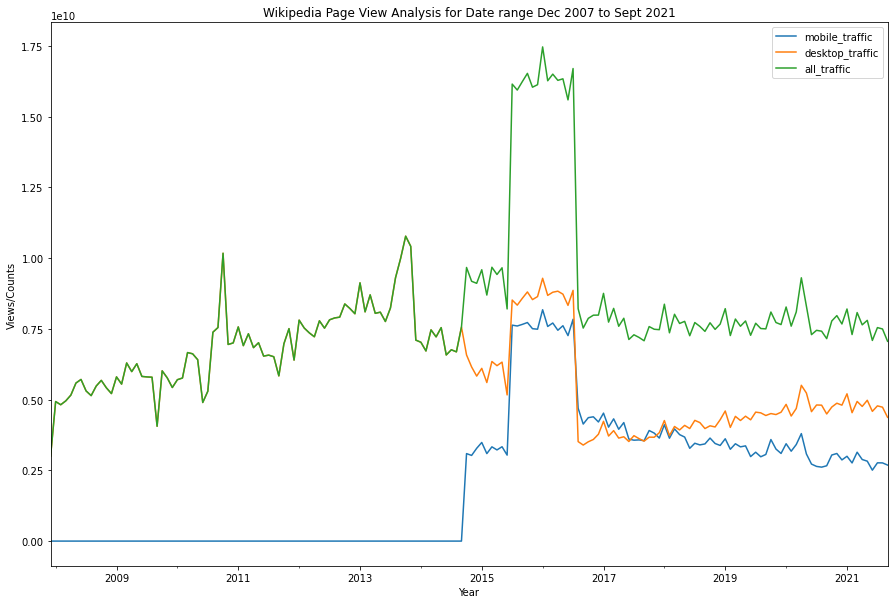

In [130]:
sum_mobile = df_all["pagecount_mobile_views"] + df_all["pageview_desktop_views"]
sum_desktop = df_all["pagecount_desktop_views"] + df_all["pageview_mobile_views"]
sum_all = df_all["pagecount_all_views"] + df_all["pageview_all_views"]

df_all["mobile_all_views"] = sum_mobile
df_all["desktop_all_views"] = sum_desktop
df_all["all_views"] = sum_all

l1 = df_all["mobile_all_views"].values
l2 = df_all["desktop_all_views"].values
l3 = df_all["all_views"].values

timeseries = np.vstack((l1, l2, l3)).T
timeseries_df = pd.DataFrame(timeseries, index=pd.date_range(start='2007-12-01', end='2021-10-01', freq='M'), columns=['mobile_traffic','desktop_traffic','all_traffic'])
timeseries_df.plot(figsize=(15,10))
plt.title('Wikipedia Page View Analysis for Date range Dec 2007 to Sept 2021')
plt.xlabel('Year')
plt.ylabel('Views/Counts')